# Prepare street names for classification
In diesem Notebook werden die Daten des [Amtliches Verzeichnis der Strassen](https://www.cadastre.ch/de/services/service/registry/street.html) für das Matching mit weiteren Datenquellen aufbereitet.

## Load Dataset
Load dataset "official list of streets" of Switzerland

In [1]:
#Load all needed libraries
import urllib.request
from zipfile import ZipFile
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Javascript
import numpy as np

In [2]:
url = 'https://data.geo.admin.ch/ch.swisstopo.amtliches-strassenverzeichnis/csv/2056/ch.swisstopo.amtliches-strassenverzeichnis.zip'
filehandle, _ = urllib.request.urlretrieve(url)

with ZipFile(filehandle, 'r') as zip:
    #zip.printdir()
    data = zip.read("pure_str.csv")
    
daten = StringIO(str(data,'UTF-8-SIG'))

streetnames = pd.read_csv(daten, encoding='UTF-8-SIG', sep=';')
streetnames.head()


,STR_ESID,STN_LABEL,ZIP_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_TYPE,STR_STATUS,STR_OFFICIAL,STR_VALID,STR_MODIFIED,STR_EASTING,STR_NORTHING
0,10258316,Eggwald,6484 Wassen UR,1220,Wassen,UR,Place,real,True,False,10.09.2022,NaN,NaN
1,10023770,Wiedenweg,4203 Grellingen,2786,Grellingen,BL,Street,real,True,True,09.09.2022,2610733.0,1254311.0
2,10179192,Wuhrbärgli,4253 Liesberg,2788,Liesberg,BL,Street,real,True,True,26.08.2022,2598709.0,1249640.0
3,10250501,Hüethütte Unter Trübsee,6390 Engelberg,1511,Wolfenschiessen,NW,Area,real,True,True,07.08.2021,2671798.0,1184817.0
4,10163108,Heimstenstich,4436 Liedertswil,2890,Liedertswil,BL,Area,real,True,True,14.10.2022,2621856.0,1248672.0


## Clean Dataset

Keep only streets (remove areas and places)
Total streetnames = 221'253 
Only with STR_TYPE = Street = 171'966 

In [3]:
streetnames = streetnames[streetnames.STR_TYPE == 'Street']

Check for missing data & remove 108 missing values in STR_EASTING & STR_NORTHING

In [4]:
missing_data = pd.DataFrame(
    streetnames.isnull().sum(),
    columns=['Missing Values'])

print(missing_data)

streetnames = streetnames.dropna()

              Missing Values
STR_ESID                   0
STN_LABEL                  0
ZIP_LABEL                  0
COM_FOSNR                  0
COM_NAME                   0
COM_CANTON                 0
STR_TYPE                   0
STR_STATUS                 0
STR_OFFICIAL               0
STR_VALID                  0
STR_MODIFIED               0
STR_EASTING              111
STR_NORTHING             111


    Check data types to streetname dataset

In [5]:
data_types = pd.DataFrame(
    streetnames.dtypes,
    columns=['Data Type'])

print(data_types)

             Data Type
STR_ESID         int64
STN_LABEL       object
ZIP_LABEL       object
COM_FOSNR        int64
COM_NAME        object
COM_CANTON      object
STR_TYPE        object
STR_STATUS      object
STR_OFFICIAL      bool
STR_VALID         bool
STR_MODIFIED    object
STR_EASTING    float64
STR_NORTHING   float64


Check if the values are unique and analyze values in columns

In [6]:
unique_values = pd.DataFrame(
    columns=['Unique Values'])
      
for row in list(streetnames.columns.values):
    unique_values.loc[row] = [streetnames[row].nunique()]
    
print(unique_values)

streetnames.groupby('STR_VALID').size()
   

              Unique Values
STR_ESID             172067
STN_LABEL             96540
ZIP_LABEL              6482
COM_FOSNR              2082
COM_NAME               2082
COM_CANTON               26
STR_TYPE                  1
STR_STATUS                2
STR_OFFICIAL              2
STR_VALID                 2
STR_MODIFIED            186
STR_EASTING          122780
STR_NORTHING         101998


STR_VALID
False      4673
True     167394
dtype: int64

Remove columns that are no longer needed.

Removed information:
STR_VALID == False: 4705 /
STR_STATUS == planned: 183 /
STR_OFFICIAL == False: 537 /
STR_TYPE: all Street /
COM_FOSNR: No analysis per ZIP planned /
STR_MODIFIED: All recently modified (oldest in 2021)

In [7]:
streetnames = streetnames.drop (['STR_TYPE', 'STR_VALID', 'STR_STATUS', 'ZIP_LABEL', 'STR_MODIFIED'], axis=1)

## Remove street terms 

Most common street names

In [8]:
most_common = streetnames.groupby("STN_LABEL").count()
most_common.COM_FOSNR.nlargest(10)

STN_LABEL
Dorfstrasse         637
Bahnhofstrasse      518
Hauptstrasse        484
Birkenweg           321
Kirchweg            313
Schulstrasse        293
Oberdorfstrasse     268
Industriestrasse    259
Schulhausstrasse    244
Rosenweg            243
Name: COM_FOSNR, dtype: int64

Count and visualize steet terms (not case sensitive)
DE: 'wegli', 'strasse', 'weg', 'platz', 'gasse', 'gässli', 'wäg',
FR: 'avenue ', 'ave. ', 'boulevard ', 'chemin ', 'impasse ', 'place', 'route ', 'rue ', 'ruelle ', 
IT: 'piazza ', 'via ', 'viale '

Important: Add spaces to words that are often string within other words (You can test ist with 'rue' vs 'rue '

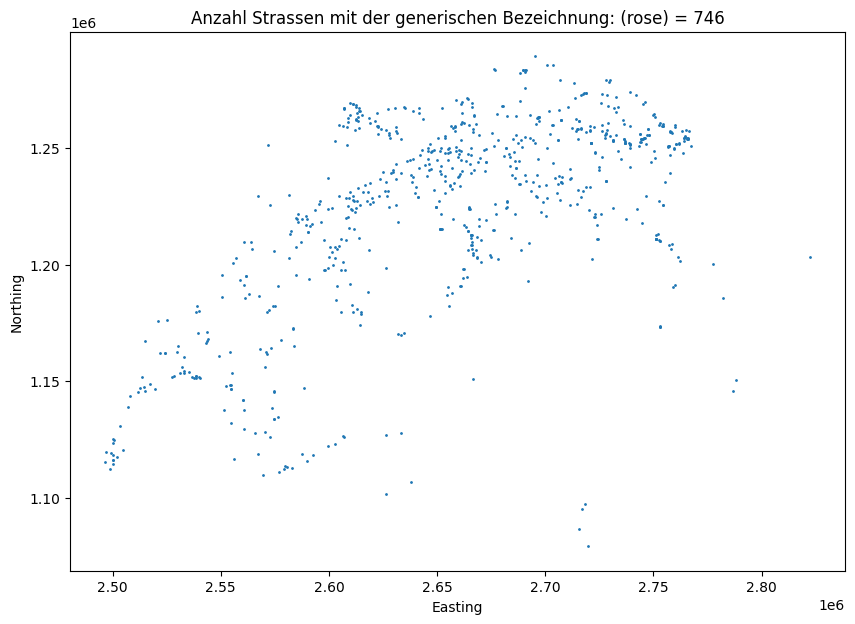

In [9]:
searchString = "rose"
searchStringStrassen = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString, case=False)]
count = len(searchStringStrassen)
count = "Anzahl Strassen mit der generischen Bezeichnung: ("+ searchString + ") = "+  str(count)

fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(x=searchStringStrassen['STR_EASTING'], y=searchStringStrassen['STR_NORTHING'], s = 1)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(count)
plt.show()

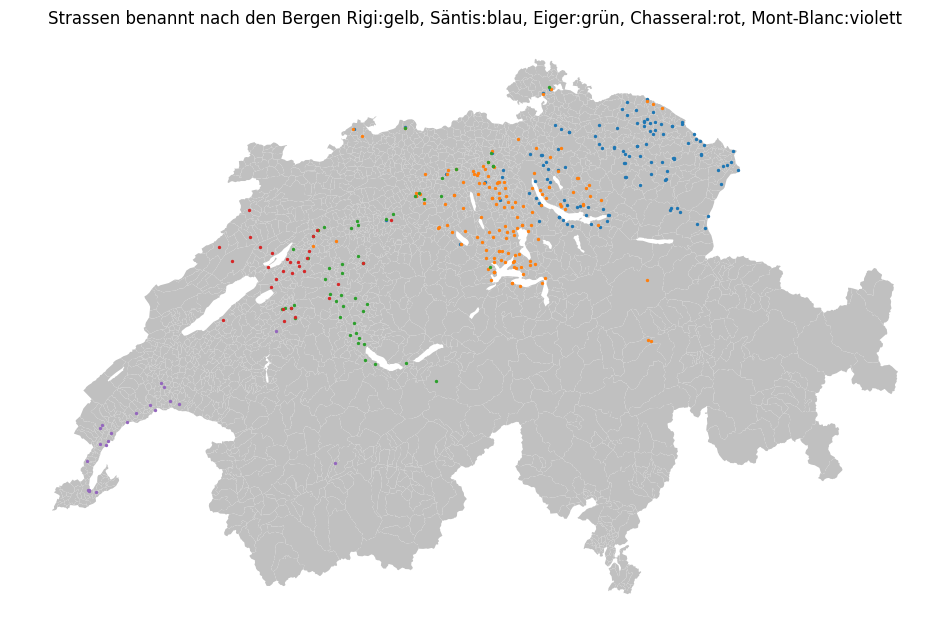

In [10]:
import geopandas
communes = geopandas.read_file('../Evaluation/data/gemeinden.geojson')

searchString = "Säntis"
searchStringStrassen = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString, case=True)]

searchString2 = "Rigi"
searchStringStrassen2 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString2, case=True)]

searchString3 = "Eiger"
searchStringStrassen3 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString3, case=True)]

searchString4 = "Chasseral"
searchStringStrassen4 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString4, case=True)]

searchString5 = "Mont-Blanc"
searchStringStrassen5 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString5, case=True)]

count = len(searchStringStrassen)
count = "Strassen benannt nach den Bergen Rigi:gelb, Säntis:blau, Eiger:grün, Chasseral:rot, Mont-Blanc:violett"

fig, ax = plt.subplots(figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
plt.scatter(x=searchStringStrassen['STR_EASTING'], y=searchStringStrassen['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen2['STR_EASTING'], y=searchStringStrassen2['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen3['STR_EASTING'], y=searchStringStrassen3['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen4['STR_EASTING'], y=searchStringStrassen4['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen5['STR_EASTING'], y=searchStringStrassen5['STR_NORTHING'], s = 2)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(count)
plt.axis('off')
plt.show()



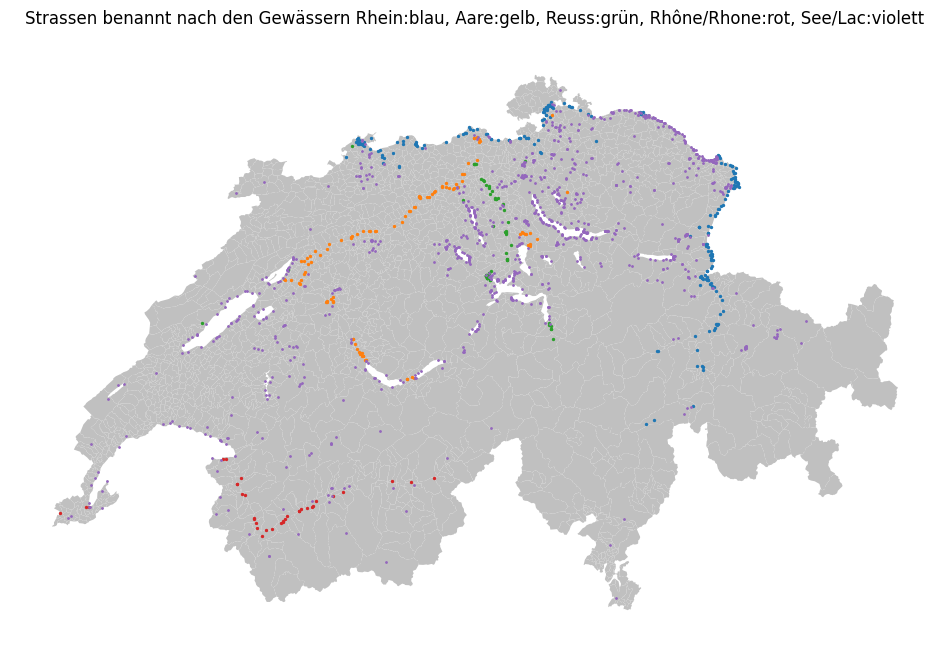

In [11]:
import geopandas
communes = geopandas.read_file('../Evaluation/data/gemeinden.geojson')

searchString = "Rhein"
searchStringStrassen = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString, case=False)]

searchString2 = "Aare"
searchStringStrassen2 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString2, case=False)]

searchString3 = "Reuss"
searchStringStrassen3 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString3, case=False)]

searchString4 = "rhône|rhone"
searchStringStrassen4 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString4, case=False)]

searchString5 = " lac|see"
searchStringStrassen5 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString5, case=False)]

count = len(searchStringStrassen)
count = "Strassen benannt nach den Gewässern Rhein:blau, Aare:gelb, Reuss:grün, Rhône/Rhone:rot, See/Lac:violett"

fig, ax = plt.subplots(figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
plt.scatter(x=searchStringStrassen['STR_EASTING'], y=searchStringStrassen['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen2['STR_EASTING'], y=searchStringStrassen2['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen3['STR_EASTING'], y=searchStringStrassen3['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen4['STR_EASTING'], y=searchStringStrassen4['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen5['STR_EASTING'], y=searchStringStrassen5['STR_NORTHING'], s = 1)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(count)
plt.axis('off')
plt.show()

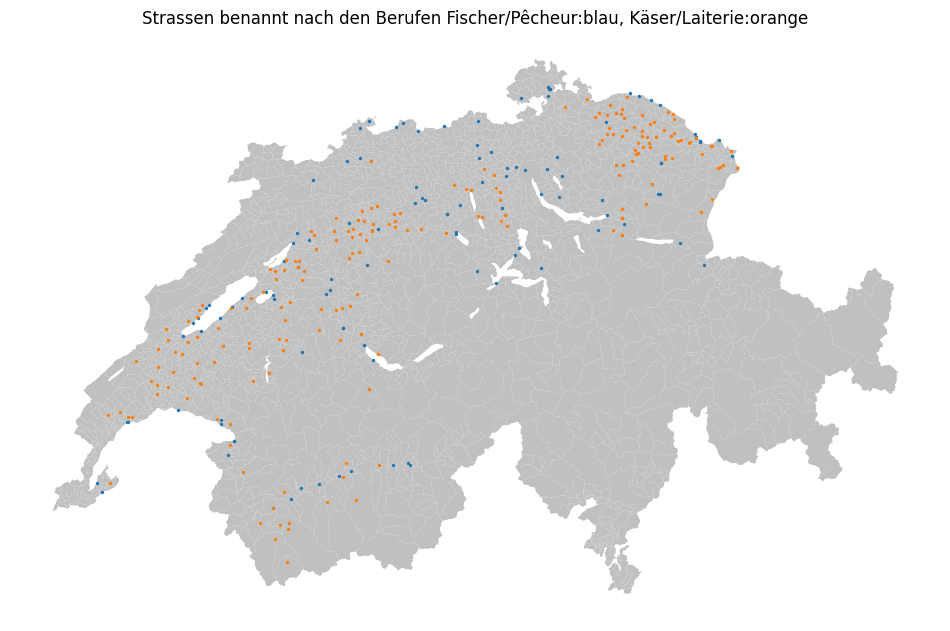

In [12]:
import geopandas
communes = geopandas.read_file('../Evaluation/data/gemeinden.geojson')

searchString = "Müller"
searchStringStrassen = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString, case=True)]

searchString2 = "Löwe"
searchStringStrassen2 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString2, case=True)]

searchString3 = "Laiterie"
searchStringStrassen3 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString3, case=True)]

searchString4 = "Fischer|Pêcheur"
searchStringStrassen4 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString4, case=True)]

searchString5 = "Käser|Laiterie"
searchStringStrassen5 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString5, case=True)]

count = len(searchStringStrassen)
count = "Strassen benannt nach den Berufen Fischer/Pêcheur:blau, Käser/Laiterie:orange"

fig, ax = plt.subplots(figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
#plt.scatter(x=searchStringStrassen['STR_EASTING'], y=searchStringStrassen['STR_NORTHING'], s = 2)
#plt.scatter(x=searchStringStrassen2['STR_EASTING'], y=searchStringStrassen2['STR_NORTHING'], s = 2)
#plt.scatter(x=searchStringStrassen3['STR_EASTING'], y=searchStringStrassen3['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen4['STR_EASTING'], y=searchStringStrassen4['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen5['STR_EASTING'], y=searchStringStrassen5['STR_NORTHING'], s = 2)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(count)
plt.axis('off')
plt.show()

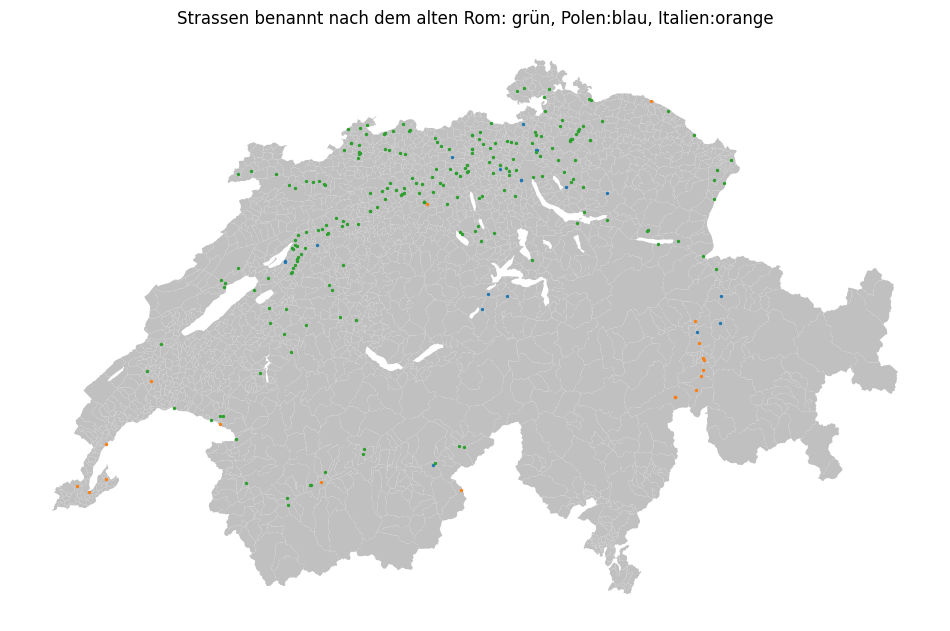

In [106]:
import geopandas
communes = geopandas.read_file('../Evaluation/data/gemeinden.geojson')

searchString = "France$"
searchStringStrassen = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString, case=True)]

searchString2 = "Deutsch|German"
searchStringStrassen2 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString2, case=True)]

searchString3 = "Polen"
searchStringStrassen3 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString3, case=True)]

searchString4 = "Italien|Italie|Italia"
searchStringStrassen4 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString4, case=True)]

searchString5 = "Römer|Romain"
searchStringStrassen5 = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString5, case=True)]

count = len(searchStringStrassen)
count = "Strassen benannt nach dem alten Rom: grün, Polen:blau, Italien:orange"

fig, ax = plt.subplots(figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
#plt.scatter(x=searchStringStrassen['STR_EASTING'], y=searchStringStrassen['STR_NORTHING'], s = 2)
#plt.scatter(x=searchStringStrassen2['STR_EASTING'], y=searchStringStrassen2['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen3['STR_EASTING'], y=searchStringStrassen3['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen4['STR_EASTING'], y=searchStringStrassen4['STR_NORTHING'], s = 2)
plt.scatter(x=searchStringStrassen5['STR_EASTING'], y=searchStringStrassen5['STR_NORTHING'], s = 2)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(count)
plt.axis('off')
plt.show()

In [14]:
#Example: filter all special street designations with ' ' (more than one word)

test = streetnames.STN_LABEL.dropna()

filter2 = test.loc[test.str.contains('rue', case=False)]

with pd.option_context("display.max_rows", 10):
    display(filter2)

count = len(filter2)
count = "Number of streets including term: "+  str(count)
print(count)

416              Chlei Bruederhölzli
449                 Rue Abbé-Gremaud
457       Rue Pierre-Nicolas-Chenaux
466            Ruelle des Liguoriens
468               Ruelle de l'Eglise
                     ...            
221279                 Rue de Cretta
221280       Rue des Proz-de-Conthey
221288            Rue de la Meunière
221292               Rue de l'Eglise
221298     Rue Marguerite-DELLENBACH
Name: STN_LABEL, Length: 7537, dtype: object

Number of streets including term: 7537


Delete spaces at the beginning and end of the string using function 'strip()'

In [15]:
#Create new Column (so we can always compare with original values)
streetnames ['STN_LABEL_NO_BI'] = streetnames.loc[:, 'STN_LABEL']

streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.strip()

Delete everything (in string) after bracket and slash. We do this mainly to keep only the first language in bilingual names.

In [16]:
streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.replace("(/).*","", regex=True)
streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.replace("(\().*","", regex=True)

#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_BI'] = streetnames['STN_LABEL_NO_BI'].str.strip()

#Check if it worked
streetnames[streetnames["STN_LABEL_NO_BI"].str.contains("Chandosselweg|Figgione")].head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI
757,10022105,Chandosselweg / Chemin de Chandossel,2250,Courgevaux,FR,True,2574274.0,1194118.0,Chandosselweg
220332,10244635,Figgione (nucleo),5072,Faido,TI,True,2706220.0,1148322.0,Figgione


Duplicate column of street names

In [17]:
streetnames ['STN_LABEL_NO_TERMS'] = streetnames.loc[:, 'STN_LABEL_NO_BI']

Move (to new column) and replace street terms

Important: Add spaces to words that are often string within other words (e.g. 'rue' vs 'rue ')
Always substring afterwards: 'wegli' before 'weg' 

In [18]:
terms = ('strasse', 'wegli', 'platz', 'gasse', 'gässli', 'wäg', 'strässli', 'allee', 'steg',
'avenue', 'boulevard', 'rue$',  'chemin ', 'impasse', 'place', 'route', 'ruelle ', 'rue ', 
'sentier', 'passage', 'promenade', 'quai', 'ruelle$', 'allée',
'piazza ', 'viale ', 
'strada ', 'veia ', 'vietta ', 'gassa ', 'voia ','voa')

terms2 = ('weg', 'via ')
    
for i in terms2:
    streetnames.loc[streetnames.STN_LABEL_NO_BI.str.contains(i,case=False), 'STR_TERMS'] = i
        
for i in terms:
    streetnames.loc[streetnames.STN_LABEL_NO_BI.str.contains(i,case=False), 'STR_TERMS'] = i
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i, '',case=False, regex=True)

for i in terms2:
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i, '',case=False, regex=True)
    
#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.strip()
streetnames['STR_TERMS'] = streetnames['STR_TERMS'].str.strip()
streetnames['STR_TERMS'] = streetnames['STR_TERMS'].replace(['allée', 'gassa', 'rue$', 'ruelle$', 'strässli'],
                                                            ['allee', 'gasse', 'rue', 'ruelle', 'strasse'])

In [19]:
streetnames.groupby('STR_TERMS',dropna=False).size()

STR_TERMS
allee          241
avenue         716
boulevard       34
chemin       14820
gasse         3831
gässli        1020
impasse       1147
passage        303
piazza          42
place          201
platz          614
promenade      246
quai           166
route         6787
rue           6270
ruelle         734
sentier        563
steg           291
strada         321
strasse      49167
veia           157
via           6928
viale           51
vietta          26
voa             59
voia            49
weg          43195
wegli          229
wäg            236
NaN          33623
dtype: int64

In [20]:
streetnames.head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS
1,10023770,Wiedenweg,2786,Grellingen,BL,True,2610733.0,1254311.0,Wiedenweg,Wieden,weg
2,10179192,Wuhrbärgli,2788,Liesberg,BL,True,2598709.0,1249640.0,Wuhrbärgli,Wuhrbärgli,NaN
9,10140563,Emanuelenweg,2829,Liestal,BL,True,2623078.0,1257558.0,Emanuelenweg,Emanuelen,weg
13,10069457,Löhrweg,2850,Känerkinden,BL,True,2630229.0,1251411.0,Löhrweg,Löhr,weg
15,10096235,Brunngasse,2833,Seltisberg,BL,True,2621406.0,1256852.0,Brunngasse,Brunn,gasse


## Remove prepositions, stopwords and special characters

First replace special caracters and punctuation marks

In [21]:
special = (['.', ' '],[',', ' '],[';', ' '],[':', ' '],['-', ' '],['\'', ' '],[',', ' '],[' ', ' '],
['è', 'e'],['é', 'e'],['ê', 'e'],['ë', 'e'],['à', 'a'],['á', 'a'],['â', 'a'],['ô', 'o'],['ò', 'o'],['ó', 'o'],
['û', 'u'],['ù', 'u'],['ú', 'u'],['ï', 'i'],['í', 'i'],['î', 'i'],['ç', 'c'])
# Not useful for matching with wikidata,['ä', 'ae'],['ü', 'ue'],['ö', 'oe']        )

for i in special:
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i[0],i[1],case=False, regex=True)
    
#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.strip()

Then move (to new column) and replace designations

For the cases with more than one designation we only keep the last designation in the dictionary.

In [22]:
terms = (['hinterer ', 'hinter'],['hinteren ', 'hinter'],['hinteres ', 'hinter'],['hintere ', 'hinter'],['hinter ', 'hinter'],
['oberen ', 'ober'],['oberer ', 'ober'],['oberes ', 'ober'],['obere ', 'ober'],['ober ', 'ober'],['oberi ', 'ober'],
['vorderen ', 'vorder'],['vorderer ', 'vorder'],['vorderes ', 'vorder'],['vordere ', 'vorder'],['vorder ', 'vorder'],
['unteren ', 'unter'],['unterer ', 'unter'],['unteres ', 'unter'],['untere ', 'unter'],['unter ', 'unter'],['sous ', 'unter'],['unterem ', 'unter'],['unterm ', 'unter'],
['mittleren ', 'mittler'],['mittlerer ', 'mittler'],['mittleres ', 'mittler'],['mittlere ', 'mittler'],['mittler ', 'mittler'],
['äusseren ', 'äusser'],['äusserer ', 'äusser'],['äusseres ', 'äusser'],['äussere ', 'äusser'],['äusser ', 'äusser'],
['inneren ', 'inner'],['innerer ', 'inner'],['inneres ', 'inner'],['innere ', 'inner'],['inner ', 'inner'],
['kleines ', 'klein'],['kleiner ', 'klein'],['kleinen ', 'klein'],['kleine ', 'klein'],['klein ', 'klein'],['petite ', 'klein'],['petit ', 'klein'],['petites ', 'klein'],
['grosses ', 'gross'],['grosser ', 'gross'],['grossen ', 'gross'],['grosse ', 'gross'],['gross ', 'gross'],['grand ', 'gross'],['grande ', 'gross'],
['san ', 'sankt'],['santa ', 'sankt'],['sankt ', 'sankt'],['sainte', 'sankt'],['saint', 'sankt'],['^st ', 'sankt'],['ste ', 'sankt'],
['ancien ', 'alt'],['ancienne ', 'alt'],['^alte ', 'alt'],['^alter ', 'alt'],['^altes ', 'alt'],['^alten ', 'alt'],['^alt ', 'alt'],
['mont ', 'mont'])

for i in terms:
    streetnames.loc[streetnames.STN_LABEL_NO_TERMS.str.contains(i[0],case=False), 'STR_PREPS'] = i[1]
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i[0],'',case=False, regex=True)
    
#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.strip()
streetnames['STR_PREPS'] = streetnames['STR_PREPS'].str.strip()

In [23]:
streetnames[streetnames["STN_LABEL"].str.contains('Wolfgalgenstutz')].head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS
33,10142028,Wolfgalgenstutz,2851,Kilchberg (BL),BL,True,2634691.0,1252654.0,Wolfgalgenstutz,Wolfgalgenstutz,NaN,NaN


In [24]:
streetnames.groupby('STR_PREPS',dropna=False).size()

STR_PREPS
alt          1092
gross         335
hinter        330
inner          61
klein         279
mittler       166
mont          115
ober         1537
sankt         869
unter        1559
vorder        191
äusser         61
NaN        165472
dtype: int64

Finally create final column (for matching with other datasets) and remove stopwords

In [25]:
streetnames ['STN_LABEL_FINAL'] = streetnames.loc[:, 'STN_LABEL_NO_TERMS']

In [26]:
stop = ('le' ,'la' , 'en' , 'au' , 'da' ,'im' , 'in' , 'ai' , 'al' ,
        'am' , 'l''','a'  ,'les', 'auf', 'aux', 'bei','der', 'die', 
        'das','zum', 'beim', 'de', 'des', 'du', 'd''', 'della', 'alla', 
        'di', 'delle', 'del', 'dei', 'den', 'dal', 'zur', 'vers',
        'Le' ,'La' , 'En' , 'Au' , 'Da' ,'Im' , 'In' , 'Ai' , 'Al' ,
        'Am' , 'L''','A'  ,'Les', 'Auf', 'Aux', 'Bei','Der', 'Die', 
        'Das','Zum', 'Beim', 'De', 'Des', 'Du', 'D''', 'Della', 'Alla', 
        'Di', 'Delle', 'Del', 'Dei', 'Den', 'Dal', 'Zur', 'Zers', 'sur', 'Sur')

#streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.lower().str.split(' ')
streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.split(' ')

streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].apply(lambda x: [item for item in x if item not in stop])

streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.join(' ')

#Delete spaces at the beginning and end of the string using function 'strip()'
streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.strip()

In [27]:
streetnames

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS,STN_LABEL_FINAL
1,10023770,Wiedenweg,2786,Grellingen,BL,True,2610733.0,1254311.0,Wiedenweg,Wieden,weg,NaN,Wieden
2,10179192,Wuhrbärgli,2788,Liesberg,BL,True,2598709.0,1249640.0,Wuhrbärgli,Wuhrbärgli,NaN,NaN,Wuhrbärgli
9,10140563,Emanuelenweg,2829,Liestal,BL,True,2623078.0,1257558.0,Emanuelenweg,Emanuelen,weg,NaN,Emanuelen
13,10069457,Löhrweg,2850,Känerkinden,BL,True,2630229.0,1251411.0,Löhrweg,Löhr,weg,NaN,Löhr
15,10096235,Brunngasse,2833,Seltisberg,BL,True,2621406.0,1256852.0,Brunngasse,Brunn,gasse,NaN,Brunn
...,...,...,...,...,...,...,...,...,...,...,...,...,...
221472,10107114,Tannenstrasse,4471,Bischofszell,TG,True,2736565.0,1261881.0,Tannenstrasse,Tannen,strasse,NaN,Tannen
221473,10070806,Rebenstrasse,4724,Eschlikon,TG,True,2716120.0,1258548.0,Rebenstrasse,Reben,strasse,NaN,Reben
221475,10142291,Fritz-Gegauf-Strasse,4864,Steckborn,TG,True,2715726.0,1280124.0,Fritz-Gegauf-Strasse,Fritz Gegauf,strasse,NaN,Fritz Gegauf
221477,10093237,Obere Bleichewiese,4571,Gachnang,TG,True,2705606.0,1266777.0,Obere Bleichewiese,Bleichewiese,NaN,ober,Bleichewiese


## Useful for optimization of designations and stop words

In [28]:
most_common = streetnames.groupby("STN_LABEL_FINAL").count()
pd.set_option('display.max_rows', 200)
most_common.COM_FOSNR.nlargest(10)

STN_LABEL_FINAL
Dorf        904
Kirch       761
Bahnhof     705
            589
Schul       573
Haupt       518
Oberdorf    481
Halden      462
Bach        414
Garten      409
Name: COM_FOSNR, dtype: int64

In [77]:
#Example: filter all special street designations with ' ' (more than one word)

test = streetnames.STN_LABEL_FINAL.dropna()

filter2 = test.loc[test.str.match('Polen', case=False)]

with pd.option_context("display.max_rows", 10):
    display(filter2)

count = len(filter2)
count = "Number of streets including term: "+  str(count)
print(count)

3501      Polenlöser
8570           Polen
12520          Polen
37805          Polen
53166          Polen
             ...    
196159         Polen
201131         Polen
203255         Polen
204829         Polen
207675         Polen
Name: STN_LABEL_FINAL, Length: 19, dtype: object

Number of streets including term: 19


In [95]:
#Example2: filter all special street designations with 'Rue' but not 'Rue.'

filter2 = streetnames.loc[(streetnames.STN_LABEL_FINAL.str.contains("Allemand")) & 
                          (~streetnames.STN_LABEL_FINAL.str.contains("Telli", regex=True))]

with pd.option_context("display.max_rows", 850):
    display(filter2)

count = len(filter2)
count = "Number of streets including term: "+  str(count)
print(count)

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS,STN_LABEL_FINAL
10749,10243128,Ruelle du Temple-Allemand,6421,La Chaux-de-Fonds,NE,True,2553693.0,1217491.0,Ruelle du Temple-Allemand,du Temple Allemand,ruelle,NaN,Temple Allemand
35932,10076315,Route des Champs Allemands,2022,Gletterens,FR,True,2561714.0,1193566.0,Route des Champs Allemands,des Champs Allemands,route,NaN,Champs Allemands
156139,10098849,Rue du Temple-Allemand,6421,La Chaux-de-Fonds,NE,True,2553315.0,1217135.0,Rue du Temple-Allemand,du Temple Allemand,rue,NaN,Temple Allemand


Number of streets including term: 3


In [31]:
missing_data = pd.DataFrame(
    streetnames.isnull().sum(),
    columns=['Missing Values'])

print(missing_data)

                    Missing Values
STR_ESID                         0
STN_LABEL                        0
COM_FOSNR                        0
COM_NAME                         0
COM_CANTON                       0
STR_OFFICIAL                     0
STR_EASTING                      0
STR_NORTHING                     0
STN_LABEL_NO_BI                  0
STN_LABEL_NO_TERMS               0
STR_TERMS                    33623
STR_PREPS                   165472
STN_LABEL_FINAL                  0


Command to run all cells above

In [32]:
missing_data = pd.DataFrame(
    streetnames.isnull().sum(),
    columns=['Missing Values'])

print(missing_data)

                    Missing Values
STR_ESID                         0
STN_LABEL                        0
COM_FOSNR                        0
COM_NAME                         0
COM_CANTON                       0
STR_OFFICIAL                     0
STR_EASTING                      0
STR_NORTHING                     0
STN_LABEL_NO_BI                  0
STN_LABEL_NO_TERMS               0
STR_TERMS                    33623
STR_PREPS                   165472
STN_LABEL_FINAL                  0


In [33]:
streetnames.head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_OFFICIAL,STR_EASTING,STR_NORTHING,STN_LABEL_NO_BI,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS,STN_LABEL_FINAL
1,10023770,Wiedenweg,2786,Grellingen,BL,True,2610733.0,1254311.0,Wiedenweg,Wieden,weg,NaN,Wieden
2,10179192,Wuhrbärgli,2788,Liesberg,BL,True,2598709.0,1249640.0,Wuhrbärgli,Wuhrbärgli,NaN,NaN,Wuhrbärgli
9,10140563,Emanuelenweg,2829,Liestal,BL,True,2623078.0,1257558.0,Emanuelenweg,Emanuelen,weg,NaN,Emanuelen
13,10069457,Löhrweg,2850,Känerkinden,BL,True,2630229.0,1251411.0,Löhrweg,Löhr,weg,NaN,Löhr
15,10096235,Brunngasse,2833,Seltisberg,BL,True,2621406.0,1256852.0,Brunngasse,Brunn,gasse,NaN,Brunn


In [34]:
streetnames.loc[[194235, 215571, 157247, 104812, 209799], ['STR_ESID', 'STN_LABEL', 'STR_TERMS', 'STN_LABEL_FINAL']]

KeyError: '[194235] not in index'

In [ ]:
streetnames.to_csv('streetnames.csv', encoding='UTF-8-SIG', sep=';')